In [1]:
import numpy as np 
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter, OrderedDict
import copy 
import pandas as pd
import time
import datetime

import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
np.random.seed(7)

Using TensorFlow backend.


In [2]:
Dataset = r'../15minute_data_newyork/15minute_data_newyork.csv'
fulldata = pd.read_csv(Dataset) 

In [3]:
data=fulldata[['dataid','local_15min','grid']]
sorteddata=data.sort_values(by = ['dataid', 'local_15min'])
ids=sorteddata['dataid'].unique().tolist()

In [4]:
housing_data = []
def convertDate(d):
    d = pd.to_datetime(d[:-3])
    return d 

for i in range(len(ids)):
    housing_data.append(sorteddata.loc[sorteddata.dataid==ids[i]])
    housing_data[i] = housing_data[i].reset_index().drop(columns=['index'])
    housing_data[i]['local_15min'] = housing_data[i]['local_15min'].apply(convertDate)
    #Convert datetimes to ints for faster ploting 
    housing_data[i]['15min_ints'] =  housing_data[i]['local_15min'].map(mdates.date2num)

In [5]:
def create_dataset(dataset, look_back=1, look_ahead=None):
	"function for creating dataset for model, X being the known data, and Y being target data"
	if look_ahead is None:
		look_ahead = look_back
	dataX, dataY = [], []
	for i in range(len(dataset)-2*look_back):
		dataX.append(dataset[i:(i+look_back), 0])
		if look_ahead == 0:
			dataY.append(dataset[i + look_back, 0])
		else:
			dataY.append(dataset[(i+look_back):(i+look_back+look_ahead), 0])
		
	return np.array(dataX), np.array(dataY)


In [6]:
def get_avg_day(look_back =96,  house = 0):

    dataframe = housing_data[house]['grid']
    fulldays=len(dataframe)//look_back
    grid_data=dataframe.to_numpy()

    grid_day_matrix=grid_data[:(look_back*fulldays)].reshape(-1, look_back)
    #avg house0 grid data 
    avg_house_grid=np.mean(grid_day_matrix, axis=0)
    # print(grid_day_matrix.shape)
    return avg_house_grid


In [7]:
avg_house0_grid = get_avg_day(house= 0)

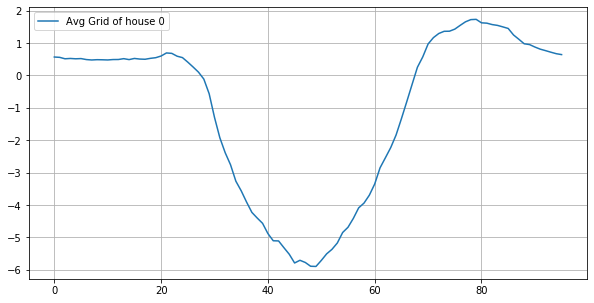

In [8]:
plt.figure(figsize=(10,5))
plt.plot(avg_house0_grid, label= 'Avg Grid of house 0' )
plt.grid(True)
plt.legend()

In [9]:
len(housing_data)

25

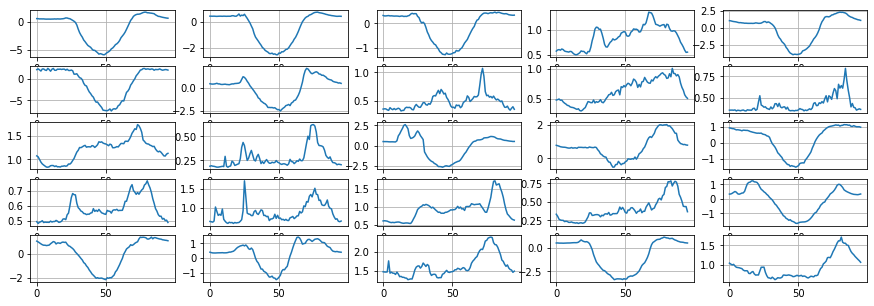

In [10]:
# avg_house_grid_list = []
plt.figure(figsize=(15,5))
for i in range(len(housing_data)):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,5,i+1) 
    plt.plot(get_avg_day(house= i))
    plt.grid(True)
# plt.grid(True)
# plt.legend()

No handles with labels found to put in legend.


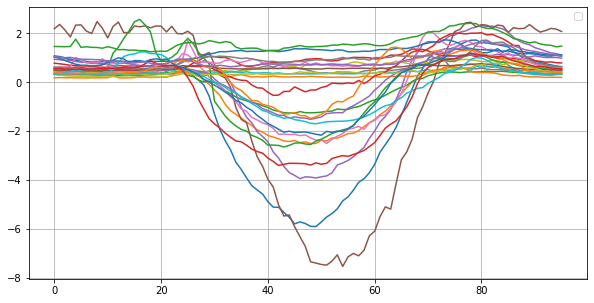

In [11]:
# avg_house_grid_list = []
plt.figure(figsize=(10,5))
for i in range(len(housing_data)):
    plt.plot(get_avg_day(house= i))
plt.grid(True)
plt.legend()